In [2]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('cleaned_data.csv')

In [4]:
y = df['readmitted']
x = df.drop(['readmitted'], axis=1)
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(x, y)
mask = selector.get_support()
selected_features = x.columns[mask]
print("Top Features:", selected_features.tolist())

Top Features: ['discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'metformin', 'change', 'diabetesMed', 'Total_visits', 'd1_Musculoskeletal', 'd1_Neoplasms', 'd1_Respiratory']


In [5]:
from imblearn.over_sampling import RandomOverSampler
X_selected = df[selected_features]
y = df['readmitted']
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_selected, y)
x_train, x_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)
# Standard Scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
print(y_train.value_counts())

readmitted
0    43891
1    43891
2    43891
Name: count, dtype: int64


In [6]:
log_model=LogisticRegression(max_iter=1000,random_state=42)
log_model.fit(x_train,y_train)
y_pred_log=log_model.predict(x_test)


In [16]:
svm_model=SVC(kernel='linear',random_state=42,max_iter=100)
svm_model.fit(x_train,y_train)
y_pred_svm=svm_model.predict(x_test)

D:\pythonn\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [17]:
rf_model=RandomForestClassifier(n_estimators=150,random_state=42)
rf_model.fit(x_train,y_train)
y_pred_rf=rf_model.predict(x_test)

In [18]:
weights = {0: 3, 1:2, 2: 2}
sample_weight = y_train.map(weights)

xgb_model = XGBClassifier(random_state=42, n_estimators=150, max_depth=6)
xgb_model.fit(x_train, y_train, sample_weight=sample_weight)

y_pred_xgb = xgb_model.predict(x_test)


In [19]:

y_proba=xgb_model.predict_proba(x_test)
y_test_bin=label_binarize(y_test,classes=[0,1,2])
roc_auc=roc_auc_score(y_test_bin,y_proba,multi_class='ovr',average='macro')
print("ROC-AUC (XGB): ", round(roc_auc, 2))

y_proba_log = log_model.predict_proba(x_test)
roc_auc_log = roc_auc_score(y_test, y_proba_log, multi_class='ovr')
print("ROC-AUC (Logistic Regression):", round(roc_auc_log, 2))

y_proba_rf = rf_model.predict_proba(x_test)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf, multi_class='ovr')
print("ROC-AUC (Random Forest):", round(roc_auc_rf, 2))

ROC-AUC (XGB):  0.74
ROC-AUC (Logistic Regression): 0.61
ROC-AUC (Random Forest): 0.97


In [20]:
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("SVM Report:\n", classification_report(y_test, y_pred_svm))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.43      0.41      0.42     10973
           1       0.38      0.21      0.27     10973
           2       0.44      0.65      0.52     10973

    accuracy                           0.42     32919
   macro avg       0.42      0.42      0.41     32919
weighted avg       0.42      0.42      0.41     32919

SVM Report:
               precision    recall  f1-score   support

           0       0.34      0.43      0.38     10973
           1       0.36      0.08      0.14     10973
           2       0.37      0.55      0.44     10973

    accuracy                           0.36     32919
   macro avg       0.36      0.36      0.32     32919
weighted avg       0.36      0.36      0.32     32919

Random Forest Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     10973
           1       0.74      0.90      0.81     10973
          

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

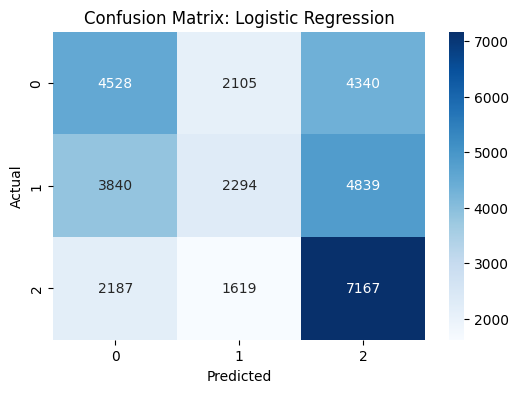

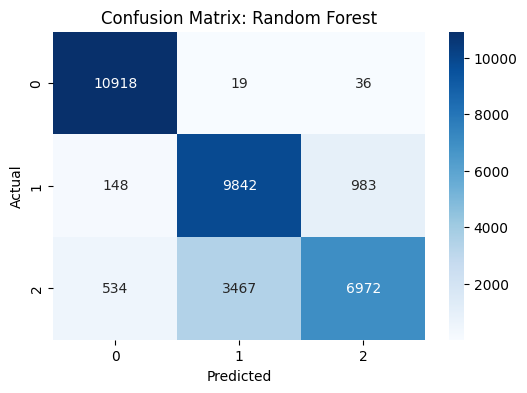

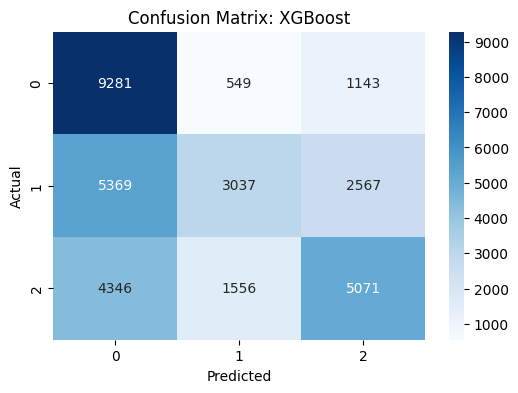

In [22]:
plot_confusion(y_test, y_pred_log, "Logistic Regression")
plot_confusion(y_test, y_pred_rf,"Random Forest")
plot_confusion(y_test, y_pred_xgb,"XGBoost")
# plot_confusion(y_test, y_pred_svm,"svm")